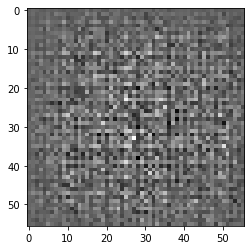

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Define the generator model
generator = tf.keras.Sequential([
            tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((7, 7, 256)),
            tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same',use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',use_bias=False, activation='tanh')
            ])

# Define the discriminator model
discriminator = tf.keras.Sequential([
                tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]),
                tf.keras.layers.LeakyReLU(),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
                tf.keras.layers.LeakyReLU(),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
                tf.keras.layers.LeakyReLU(),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1)
                ])

# Define the loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    # Apply gradients to the discriminator variables
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    
    # Train the generator
    with tf.GradientTape() as gen_tape:
        # Generate fake images using the generator
        generated_images = generator(noise, training=True)
        # Get discriminator's prediction of the generated images
        gen_preds = discriminator(generated_images, training=False)
        # Calculate generator's loss
        gen_loss = generator_loss(gen_preds)
        
    # Get gradients of the generator loss with respect to the generator variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Apply gradients to the generator variables
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    # Print the losses
    print("Discriminator loss:", disc_loss.numpy(), "Generator loss:", gen_loss.numpy())
    
    # Save checkpoint
    ckpt_manager.save()
    
# Generate and save 10 random images from the generator after training
NOISE_DIM = 100

for i in range(10):
    noise = tf.random.normal([1, NOISE_DIM])
    generated_images = generator(noise, training=False)
    img = tf.squeeze(generated_images[0])
    plt.imshow(img, cmap='gray')
    plt.savefig(f'generated_image_{i}.png')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Check if TensorFlow is able to detect a GPU
print(tf.config.list_physical_devices('GPU'))

# Set the GPU device to use
device_name = '/device:GPU:0'

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (_, _) = mnist.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5

# Reshape the images to (28, 28, 1) and add a channel dimension
train_images = np.expand_dims(train_images, axis=-1)

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False,input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2),padding='same', input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2),padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

@tf.function
def train_step(images):
    #Generate noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #Generate fake images
        generated_images = generator(noise, training=True)
        # Evaluate discriminator on real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Calculate the losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    # Apply gradients to the discriminator variables
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    # Generate images from the model
    predictions = model(test_input, training=False)
    # Rescale to [0, 1]
    predictions = (predictions + 1) / 2.0
    
    # Plot the images
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
    # Save the figure
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
# Generate a fixed set of noise for evaluating the model during training
fixed_noise = tf.random.normal([num_examples_to_generate, noise_dim])

# Train the model
for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        train_step(image_batch)
    # Generate and save images every 10 epochs
    if (epoch + 1) % 10 == 0:
        generate_and_save_images(generator, epoch + 1, fixed_noise)
    
    # Print progress every epoch
    print('Epoch {} completed'.format(epoch + 1))

[]
Epoch 1 completed
Epoch 2 completed


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"